# To do:

 - Figure out how to signal injuries

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import duckdb
import warnings
import math         # haversine_km()
import os

import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import randint, uniform

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib
import warnings
from datetime import datetime, timedelta
from haversine import haversine

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

categories = ['PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK']
con = duckdb.connect(database=":memory:")

cwd = os.path.abspath(os.getcwd()).replace("\\", "/")
if cwd.startswith("C:/Users/Rodolfo/"):
    RUN_LOCATION = "local"
else:
    RUN_LOCATION = "cloud"
time_offset = {"local": 3, "cloud": -5}
now = str((datetime.now() + timedelta(hours=time_offset[RUN_LOCATION]) + timedelta(hours=-3)).date())
print(f"Today's date:", now)

tgt_stat = "PRA"
print('Target Stat:', tgt_stat)

Today's date: 2026-01-03
Target Stat: PRA


In [59]:
%run ./common_utils.ipynb

# ML Functions

In [60]:
def feature_importance(model):
    importance = model.get_score(importance_type='gain')

    # Convert to table
    df_importance = (
        pd.DataFrame({
            'feature': list(importance.keys()),
            'importance': list(importance.values())
        })
        .sort_values(by='importance', ascending=False)
        .reset_index(drop=True)
    )

    df_importance['pct'] = df_importance.importance.cumsum() / df_importance.importance.sum()
    display(df_importance)

    xgb.plot_importance(model)
    plt.show()

In [61]:
def create_baseline_model(df, pred_col, DFS):
    
    train_df, val_df, test_df = DFS

    if pred_col == 'MP':
        print('Minutes Model')
        feature_cols = [
            'MP_lst_gm',
            'MP_last_5_avg',
            'MP_last_10_avg',
            'starter', 'bench', 'reserve'
        ]
    else:
        print(f'{pred_col} Stats Model')
        feature_cols = [
            'MP_lst_gm',
            'MP_last_5_avg',
            'MP_last_10_avg',
            f'{pred_col}_last_3_avg', f'{pred_col}_last_5_avg', f'{pred_col}_last_10_avg',
            f'Def_{pred_col}', f'Def_L5_{pred_col}'
        ]
    
    print('Train:', len(train_df), '/ Validation:', len(val_df), '/ Test:', len(test_df))
    
    X_train, y_train = train_df[feature_cols], train_df[pred_col]
    X_val,   y_val   = val_df[feature_cols],   val_df[pred_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[pred_col]

    # Convert to DMatrix (XGBoost internal format)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    params = {
        "objective": "reg:squarederror",
        "max_depth": 5,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42
    }

    # Train using native XGBoost API with early stopping
    evals = [(dtrain, "train"), (dval, "val")]
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Predict on test set
    preds = bst.predict(dtest)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)
    
    return bst

In [62]:
def hyperparam_tuning(DFS, pred_col, n_iter=20, early_stopping_rounds=50):
    """
    Hyperparameter tuning using native XGBoost API and DMatrix,
    with early stopping support (compatible with XGBoost 3.1.2)
    """

    train_df, val_df, test_df = DFS
    feature_cols = [col for col in train_df.columns if col not in ['Date', pred_col]]
    X_train, y_train = train_df[feature_cols], train_df[pred_col]
    X_val,   y_val   = val_df[feature_cols],   val_df[pred_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[pred_col]

    # Convert datasets to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    # Hyperparameter search space
    param_dist = {
        "n_estimators": randint(300, 1500),
        "learning_rate": uniform(0.01, 0.05),
        "max_depth": randint(3, 6),
        "min_child_weight": randint(1, 8),
        "subsample": uniform(0.7, 0.3),
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 2),
        "reg_lambda": uniform(0, 5),
        "reg_alpha": uniform(0, 2)
    }

    # Sample n_iter random parameter combinations
    param_list = []
    for _ in range(n_iter):
        sample = {k: (v.rvs() if hasattr(v, "rvs") else v) for k, v in param_dist.items()}
        sample['n_estimators'] = int(sample['n_estimators'])
        sample['max_depth'] = int(sample['max_depth'])
        sample['min_child_weight'] = int(sample['min_child_weight'])
        param_list.append(sample)

    best_mae = float('inf')
    best_params = None
    best_bst = None

    # Manual hyperparameter search
    for i, params in enumerate(param_list):
        print(f"\nTrial {i+1}/{n_iter}: {params}")
        num_boost_round = params.pop('n_estimators')
        params.update({
            "objective": "reg:squarederror",
            "tree_method": "hist",
            "device": "cuda",
            "seed": 42
        })
        evals = [(dtrain, 'train'), (dval, 'val')]
        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )
        # Predict on validation set to compute MAE
        val_preds = bst.predict(dval, iteration_range=(0, bst.best_iteration))
        mae = mean_absolute_error(y_val, val_preds)
        print(f"Validation MAE: {mae:.4f}")
        if mae < best_mae:
            best_mae = mae
            best_params = params.copy()
            best_bst = bst

    print("\nBest validation MAE:", best_mae)
    print("Best parameters:", best_params)

    # Predict on test set using best model
    preds = best_bst.predict(dtest, iteration_range=(0, best_bst.best_iteration))
    test_df[pred_col] = y_test
    test_df[f'{pred_col}_preds'] = preds
    test_df['Team'] = team_encoder.inverse_transform(test_df["Team"])
    test_df['Opp'] = team_encoder.inverse_transform(test_df["Opp"])
    test_df['Player'] = player_encoder.inverse_transform(test_df["Player"])
    test_df['Pos'] = position_encoder.inverse_transform(test_df["Pos"])
    analyze_df = test_df[['Date', 'Team', 'Player', 'Pos', 'Opp', pred_col, f'{pred_col}_preds']]
    print("\nTest Metrics:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
    print("MAE:", mean_absolute_error(y_test, preds))
    print("R²:", r2_score(y_test, preds))

    return best_bst, preds, y_test, analyze_df

### Create Base df

In [86]:
df = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()
for i in [2022, 2023, 2024, 2025]:
    df_actuals = pd.read_csv(f"../tables/{i}/parlay_stats.csv")
    df_actuals['Season'] = i
    df = pd.concat([df, df_actuals])

    df_schd = pd.read_csv(f"../tables/{i}/nba_schedule.csv")
    df_schd['Season'] = i
    df2 = pd.concat([df2, df_schd])
    
    df_gms = pd.read_csv(f"../tables/{i}/season_gamelogs.csv")
    df_gms['Season'] = i
    df3 = pd.concat([df3, df_gms])
    
    df_inj = pd.read_csv(f"../tables/{i}/injuries.csv")
    df_inj['Season'] = i
    df4 = pd.concat([df4, df_inj])

df['Date'] = pd.to_datetime(df.Date)
df2['Date'] = pd.to_datetime(df2.Date)
df3['Date'] = pd.to_datetime(df3.Date)
df3 = df3[~df3[['Date', 'Team', 'Player']].duplicated(keep='last')]
df4['Date'] = pd.to_datetime(df4.Date)

df3 = df3.rename(columns={"3PM": "TPM", "3PA": "TPA", "3P%": "TP%", "TRB": "REB"}).drop(['Pos', 'Opp'], axis=1)
df3['PR'] = df3.PTS + df3.REB 
df3['PA'] = df3.PTS + df3.AST
df3['RA'] = df3.REB + df3.AST
df3['PRA'] = df3.PTS + df3.REB + df3.AST
df3['STL_BLK'] = df3.STL + df3.BLK
df = df.merge(df3, on=['Season', 'Date', 'Team', 'Player'], how='left')

df_mtch = df2[['Season', 'Date', 'AwayABV', 'HomeABV', 'AwayPTS', 'HomePTS', 'AwayB2B', 'HomeB2B', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch['Team_type'] = 'Away'
df_mtch = df_mtch.rename(columns={"AwayABV": "Team", "HomeABV": "Opp", "AwayB2B": "B2B"})[['Season', 'Date', 'Team', 'AwayPTS', 'HomePTS', 'Opp', 'B2B', 'is_OT', 'cup_gm', 'pstszn_gm', 'Team_type']]
df_mtch2 = df_mtch.copy().rename(columns={"Team": "Opp", "Opp": "Team", "HomeB2B": "B2B"})[['Season', 'Date', 'Team', 'AwayPTS', 'HomePTS', 'Opp', 'B2B', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch2['Team_type'] = 'Home'
df_mtch = pd.concat([df_mtch, df_mtch2])
df_mtch = df_mtch[['Season', 'Date', 'Team', 'Team_type', 'AwayPTS', 'HomePTS', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch = df_mtch.sort_values(["Team", "Date"])
df_mtch['team_game_num'] = df_mtch.groupby(["Team", "Season"]).cumcount() + 1
df_mtch['Spread'] = np.where(df_mtch.Team_type == 'Home', df_mtch.HomePTS - df_mtch.AwayPTS, df_mtch.AwayPTS - df_mtch.HomePTS)
df_mtch['Total'] = df_mtch.AwayPTS + df_mtch.HomePTS
df_mtch['is_Win'] = np.where(df_mtch.Spread > 0, 1, 0)
df_mtch['Szn_Wins'] = df_mtch.groupby(['Season', 'Team'])['is_Win'].cumsum()
df = df.drop(['Season', 'Team_type'], axis=1).merge(df_mtch, on=['Date', 'Team'])

df = df.merge(df4[['Date', 'Team', 'Player', 'Status']], on=['Date', 'Team', 'Player'], how='left')
df['Status'] = np.where((df.Active == 1) & (df.Status.isnull()), 'Available', df.Status)
df['Status'] = np.where((df.Active == 0), 'Out', df.Status)
df['Status'] = np.where((df.Status == 'Out') & (df.Active != 0), 'Available', df.Status)

team_encoder = LabelEncoder()
player_encoder = LabelEncoder()
team_type_encoder = LabelEncoder()
position_encoder = LabelEncoder()
status_encoder = LabelEncoder()

# Encode string cols
team_encoder.fit(pd.concat([df["Team"], df["Opp"]], axis=0))
df["Team"] = team_encoder.transform(df["Team"])
df["Opp"] = team_encoder.transform(df["Opp"])
df["Player_name"] = df.Player
df["Player"] = player_encoder.fit_transform(df["Player"])
df["Pos"] = position_encoder.fit_transform(df["Pos"])
df['Team_type'] = team_type_encoder.fit_transform(df['Team_type'])
df["Status"] = status_encoder.fit_transform(df["Status"])
df_pred = df.copy()
df = df[(df.Active == 1) & (df.MP > 0)].sort_values(['Season', 'Date', 'Team', 'Player']).reset_index(drop=True)
print('base df created', datetime.now())

base df created 2026-01-03 15:33:38.879021


In [56]:
df3_temp = df3.copy().drop('Season', axis=1)
df4_temp = df4.copy().drop('Season', axis=1)
# display(df3_temp[(df3_temp.Date == '2025-12-25') & (df3_temp.game_id == '20251225_CLE_NYK')])
df_temp = df4_temp.merge(df3_temp, on=['Date', 'Team', 'Player'], how='outer')
df_temp['game_id'] = np.where(df_temp.game_id.isnull(), )

df_temp = df_temp[(df_temp.Date == '2025-12-25') & (df_temp.Team.isin(['CLE', 'NYK']))]
display(df_temp)

,Date,Team,Player,Status,Reason,game_id,Team_type,Opp_type,Active,MP,FG,FGA,FG%,TPM,TPA,TP%,FT,FTA,FT%,ORB,DRB,REB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,DD,TD,Fpts,PR,PA,RA,PRA,STL_BLK
134481,2025-12-25,CLE,Chris Livingston,Out,G League - Two-Way,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134482,2025-12-25,CLE,Craig Porter Jr.,NaN,NaN,20251225_CLE_NYK,Away,Home,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134483,2025-12-25,CLE,Darius Garland,NaN,NaN,20251225_CLE_NYK,Away,Home,1.0,36.00,7.0,14.0,0.500,3.0,4.0,0.750,3.0,4.0,0.750,0.0,1.0,1.0,10.0,0.0,0.0,4.0,2.0,20.0,15.1,0.0,1.0,0.0,19.5,21.0,30.0,11.0,31.0,0.0
134484,2025-12-25,CLE,De'Andre Hunter,NaN,NaN,20251225_CLE_NYK,Away,Home,1.0,27.10,3.0,7.0,0.429,2.0,3.0,0.667,5.0,6.0,0.833,0.0,3.0,3.0,2.0,0.0,0.0,0.0,1.0,13.0,10.8,-7.0,0.0,0.0,12.5,16.0,15.0,5.0,18.0,0.0
134485,2025-12-25,CLE,Dean Wade,NaN,NaN,20251225_CLE_NYK,Away,Home,1.0,29.47,2.0,4.0,0.500,1.0,3.0,0.333,1.0,1.0,1.000,1.0,3.0,4.0,2.0,0.0,0.0,0.0,2.0,6.0,6.2,-2.0,0.0,0.0,9.5,10.0,8.0,6.0,12.0,0.0
134486,2025-12-25,CLE,Donovan Mitchell,NaN,NaN,20251225_CLE_NYK,Away,Home,1.0,32.85,12.0,25.0,0.480,4.0,9.0,0.444,6.0,6.0,1.000,0.0,7.0,7.0,6.0,4.0,0.0,1.0,3.0,34.0,29.4,2.0,0.0,0.0,39.0,41.0,40.0,13.0,47.0,4.0
134487,2025-12-25,CLE,Evan Mobley,NaN,NaN,20251225_CLE_NYK,Away,Home,1.0,25.32,6.0,8.0,0.750,0.0,1.0,0.000,2.0,2.0,1.000,2.0,7.0,9.0,3.0,0.0,0.0,2.0,4.0,14.0,12.8,4.0,0.0,0.0,17.0,23.0,17.0,12.0,26.0,0.0
134488,2025-12-25,CLE,Jarrett Allen,NaN,NaN,20251225_CLE_NYK,Away,Home,1.0,23.12,3.0,4.0,0.750,0.0,0.0,0.000,1.0,2.0,0.500,2.0,6.0,8.0,2.0,0.0,0.0,2.0,3.0,7.0,6.4,-3.0,0.0,0.0,11.5,15.0,9.0,10.0,17.0,0.0
134489,2025-12-25,CLE,Jaylon Tyson,NaN,NaN,20251225_CLE_NYK,Away,Home,1.0,20.08,7.0,11.0,0.636,2.0,4.0,0.500,0.0,0.0,0.000,2.0,4.0,6.0,1.0,1.0,0.0,2.0,4.0,16.0,11.8,-1.0,0.0,0.0,16.0,22.0,17.0,7.0,23.0,1.0
134490,2025-12-25,CLE,Larry Nance Jr.,Out,Injury/Illness - Right Calf; Strain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Minutes Projection Model

In [43]:
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def travel_km_from_row(row):
    prev = row['PrevLocation']
    cur  = row['Location']
    # missing prev => first game => no travel
    if pd.isna(prev) or pd.isna(cur):
        return 0.0
    # same arena => 0
    if prev == cur:
        return 0.0
    # lookup coords
    prev_coords = arenas.get(prev)
    cur_coords  = arenas.get(cur)
    if not prev_coords or not cur_coords:
        # fallback if code not found
        return 0.0
    return haversine_km(prev_coords[0], prev_coords[1], cur_coords[0], cur_coords[1])

In [44]:
def setup_df_mins(con, df):
    
    df = df[['Season', 'Date', 'Team', 'Team_type', 'Opp', 'Player', 'Pos', 'B2B', 'MP', 'TOV', 'PF', '+/-',
             'Spread', 'Total', 'team_game_num', 'Szn_Wins', 'cup_gm', 'pstszn_gm', 'is_OT']]
    
    for col in ['MP', 'TOV', 'PF', '+/-']:
        df[f'{col}_lst_gm'] = (
            df
            .groupby(['Player', 'Season'])[col]
            .shift(1)
        )
        for N in [3, 5, 10]:
            df[f'{col}_last_{N}_avg'] = (
                df.groupby(['Player', 'Season'])[col]
                  .rolling(window=N, min_periods=1)
                  .mean()
                  .shift(1)
                  .reset_index(level=[0, 1], drop=True)
            )
            df[f"{col}_last_{N}_std"] = (
                df.groupby(['Player', 'Season'])[col]
                  .shift(1)
                  .rolling(window=N, min_periods=1)
                  .std()
            )
        df[f"{col}_change_L1"] = df[f"{col}_lst_gm"] - df[f"{col}_last_5_avg"]
        df[f"{col}_change_L3"] = df[f"{col}_last_3_avg"] - df[f"{col}_last_10_avg"]
        df[f"{col}_pct_change"] = (
            (df[f"{col}_lst_gm"] - df[f"{col}_last_10_avg"]) /
            (df[f"{col}_last_10_avg"] + 1e-6)
        )
    df["MP_spike"] = (df["MP_lst_gm"] > df["MP_last_10_avg"] + 8).astype(int)
    df["MP_drop"]  = (df["MP_lst_gm"] < df["MP_last_10_avg"] - 8).astype(int)
    df["MP_trend"] = df["MP_last_3_avg"] - df["MP_last_10_avg"]

    games_last_7_days = df.groupby(['Player', 'Season']).rolling('7D', on='Date')['MP'].count().shift(1).to_frame(name='games_last_7_days').reset_index()
    games_last_7_days = games_last_7_days.drop_duplicates(
        subset=['Player', 'Season', 'Date']
    )
    df = df.merge(games_last_7_days, on=['Player', 'Season', 'Date'])
    df['games_last_7_days'] = df.games_last_7_days.fillna(0).astype(int)
    
    df['prev_team_mins_pct'] = (df.groupby(['Player', 'Season'])['MP'].shift(1)) / 240
           
    df['reserve_td'] = (df.MP < 8).astype(int)
    df['bench_td']   = ((df.MP >= 8) & (df.MP <= 25)).astype(int)
    df['starter_td'] = (df.MP > 25).astype(int)
    role_counts = df.groupby(['Season', 'Player'])[['reserve_td', 'bench_td', 'starter_td']].sum()
    role_counts['most_common_role'] = role_counts[['reserve_td', 'bench_td', 'starter_td']].idxmax(axis=1)
    role_counts['reserve'] = (role_counts['most_common_role'] == 'reserve_td').astype(int)
    role_counts['bench']   = (role_counts['most_common_role'] == 'bench_td').astype(int)
    role_counts['starter'] = (role_counts['most_common_role'] == 'starter_td').astype(int)
    df = df.merge(role_counts[['reserve', 'bench', 'starter']], on=['Season', 'Player'], how='left')
    
    df['role'] = 0
    df['role'] = np.where(df.starter == 1, 1, df.role)
    df['role'] = np.where(df.bench == 1, 2, df.role)
    df['role'] = np.where(df.reserve == 1, 3, df.role)
      
    df['missed_games'] = (
        df.groupby(['Player', 'Team', 'Season'])['team_game_num']      
          .diff()
          .sub(1)
          .fillna(0)
          .astype(int)
    )
    
    df['blowout'] = np.where(abs(df.Spread >= 15), 1, 0)
    
    # Location based features
    df["PrevOpp"] = df.groupby("Player")["Opp"].shift(1)
    df["DaysLstGm"] = (df.groupby("Player")["Date"].diff().dt.days).fillna(0).astype(int)
    df['Location'] = df.apply(lambda r: r['Team'] if r['Team_type'] == 'Home' else r['Opp'], axis=1)
    df['PrevLocation'] = df.groupby('Player')['Location'].shift(1)
    df['travel_km'] = df.apply(travel_km_from_row, axis=1).fillna(0)
    df['travel_hours'] = df['travel_km'] / 800.0      # approximate flight hours
    df['is_long_trip'] = (df['travel_km'] > 1500).astype(int)
    df['same_arena'] = (df['PrevLocation'] == df['Location']).astype(int)
    
    df = df.drop(['Season', 'reserve_td', 'reserve', 'bench_td', 'bench', 'starter_td', 'starter', 'Szn_Wins', 'TOV', 'PF', '+/-', 
                  'PrevOpp', 'PrevLocation', 'Location'], axis=1)    
    
    return df

In [45]:
df_mins = df.copy()
df_mins = setup_df_mins(con, df_mins)
display(df_mins)

n = len(df_mins)
train_end = int(0.8 * n)
val_end   = int(0.9 * n)
mins_train_df = df_mins.iloc[:train_end]
mins_val_df   = df_mins.iloc[train_end:val_end]
mins_test_df  = df_mins.iloc[val_end:]
mins_DFS = (mins_train_df, mins_val_df, mins_test_df)

# mins_model = create_baseline_model(df_mins, "MP", mins_DFS)
mins_model, mins_preds, y_test_mins, analyze_df_mins = hyperparam_tuning(mins_DFS, "MP", n_iter=1)
# feature_importance(mins_model)

# mins_model.save_model("../ML_models/mins_model.json")
# print('Saved minutes model!')

,Date,Team,Team_type,Opp,Player,Pos,B2B,MP,Spread,Total,team_game_num,cup_gm,pstszn_gm,is_OT,MP_lst_gm,MP_last_3_avg,MP_last_3_std,MP_last_5_avg,MP_last_5_std,MP_last_10_avg,MP_last_10_std,MP_change_L1,MP_change_L3,MP_pct_change,TOV_lst_gm,TOV_last_3_avg,TOV_last_3_std,TOV_last_5_avg,TOV_last_5_std,TOV_last_10_avg,TOV_last_10_std,TOV_change_L1,TOV_change_L3,TOV_pct_change,PF_lst_gm,PF_last_3_avg,PF_last_3_std,PF_last_5_avg,PF_last_5_std,PF_last_10_avg,PF_last_10_std,PF_change_L1,PF_change_L3,PF_pct_change,+/-_lst_gm,+/-_last_3_avg,+/-_last_3_std,+/-_last_5_avg,+/-_last_5_std,+/-_last_10_avg,+/-_last_10_std,+/-_change_L1,+/-_change_L3,+/-_pct_change,MP_spike,MP_drop,MP_trend,games_last_7_days,prev_team_mins_pct,role,missed_games,blowout,DaysLstGm,travel_km,travel_hours,is_long_trip,same_arena
0,2022-10-18,1,1,22,15,0,0,23.10,9.0,243.0,1,0,0,0,NaN,23.850000,NaN,22.776,NaN,23.716,NaN,NaN,0.134000,NaN,NaN,1.666667,NaN,1.6,NaN,1.2,NaN,NaN,0.466667,NaN,NaN,2.333333,NaN,3.0,NaN,2.5,NaN,NaN,-0.166667,NaN,NaN,8.666667,NaN,8.2,NaN,10.4,NaN,NaN,-1.733333,NaN,0,0,0.134000,4,NaN,1,0,0,0,0.0,0.0,0,0
1,2022-10-18,1,1,22,61,0,0,8.28,9.0,243.0,1,0,0,0,NaN,5.410000,NaN,3.964,NaN,6.374,NaN,NaN,-0.964000,NaN,NaN,0.333333,NaN,0.2,NaN,0.3,NaN,NaN,0.033333,NaN,NaN,0.333333,NaN,0.2,NaN,1.0,NaN,NaN,-0.666667,NaN,NaN,-2.333333,NaN,-1.0,NaN,-3.0,NaN,NaN,0.666667,NaN,0,0,-0.964000,2,NaN,2,0,0,0,0.0,0.0,0,0
2,2022-10-18,1,1,22,189,4,0,24.03,9.0,243.0,1,0,0,0,NaN,11.733333,NaN,13.474,NaN,12.434,NaN,NaN,-0.700667,NaN,NaN,2.000000,NaN,1.2,NaN,1.0,NaN,NaN,1.000000,NaN,NaN,0.333333,NaN,0.4,NaN,0.3,NaN,NaN,0.033333,NaN,NaN,-1.000000,NaN,-0.2,NaN,-1.3,NaN,NaN,0.300000,NaN,0,0,-0.700667,3,NaN,1,0,0,0,0.0,0.0,0,0
3,2022-10-18,1,1,22,257,1,0,23.95,9.0,243.0,1,0,0,0,NaN,14.046667,NaN,14.498,NaN,14.405,NaN,NaN,-0.358333,NaN,NaN,0.333333,NaN,0.4,NaN,0.6,NaN,NaN,-0.266667,NaN,NaN,1.333333,NaN,1.4,NaN,1.3,NaN,NaN,0.033333,NaN,NaN,-1.666667,NaN,-3.0,NaN,-4.5,NaN,NaN,2.833333,NaN,0,0,-0.358333,4,NaN,1,0,0,0,0.0,0.0,0,0
4,2022-10-18,1,1,22,357,3,0,38.57,9.0,243.0,1,0,0,0,NaN,15.055000,NaN,15.055,NaN,15.055,NaN,NaN,0.000000,NaN,NaN,1.500000,NaN,1.5,NaN,1.5,NaN,NaN,0.000000,NaN,NaN,1.000000,NaN,1.0,NaN,1.0,NaN,NaN,0.000000,NaN,NaN,-8.000000,NaN,-8.0,NaN,-8.0,NaN,NaN,0.000000,NaN,0,0,0.000000,2,NaN,1,0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84329,2026-01-02,29,1,2,428,3,1,24.60,20.0,218.0,33,0,0,0,32.55,28.206667,5.046844,25.258,4.061203,23.974,9.332733,7.292,4.232667,0.357721,0.0,0.666667,1.00000,0.4,0.836660,0.4,1.100505,-0.4,0.266667,-0.999998,1.0,2.333333,1.000000,2.4,1.870829,2.2,1.581139,-1.4,0.133333,-0.545454,4.0,-1.000000,10.440307,0.0,8.043631,1.0,9.046178,4.0,-2.000000,2.999997,1,0,4.232667,4,0.135625,2,0,1,2,0.0,0.0,0,0
84330,2026-01-02,29,1,2,476,3,1,22.83,20.0,218.0,33,0,0,0,22.63,21.520000,5.676067,21.706,4.818207,24.625,8.425520,0.924,-3.105000,-0.081015,0.0,0.666667,0.57735,0.6,0.836660,1.5,1.100505,-0.6,-0.833333,-0.999999,5.0,2.333333,2.645751,2.2,2.302173,2.4,1.911951,2.8,-0.066667,1.083333,-7.0,3.000000,8.621678,-0.6,8.348653,-0.9,8.941787,-6.4,3.900000,6.777785,0,0,-3.105000,3,0.094292,2,0,1,2,0.0,0.0,0,0
84331,2026-01-02,29,1,2,542,1,1,16.87,20.0,218.0,33,0,0,0,19.62,21.150000,6.765740,21.236,5.928336,23.119,5.274862,-1.616,-1.969000,-0.151347,1.0,0.666667,0.57735,0.4,0.836660,1.1,1.032796,0.6,-0.433333,-0.090909,2.0,1.000000,2.081666,1.4,1.870829,2.4,1.885618,0.6,-1.400000,-0.166667,6.0,5.666667,7.000000,3.8,8.700575,3.7,9.046178,2.2,1.966667,0.621621,0,0,-1.969000,4,0.081750,2,0,1,2,0.0,0.0,0,0
84332,2026-01-02,29,1,2,739,4,1,28.00,20.0,218.0,33,0,0,0,28.37,26.340000,4.445413,24.012,5.809890,22.344,5.360078,4.358,3.996000,0.269692,1.0,1.666667,0.57735,1.4,0.547723,1.2,0.948683,-0.4,0.466667,-0.166667,1.0,1.


Trial 1/1: {'n_estimators': 956, 'learning_rate': np.float64(0.02152537544690423), 'max_depth': 5, 'min_child_weight': 4, 'subsample': np.float64(0.8526774353517266), 'colsample_bytree': np.float64(0.8342868743740608), 'gamma': np.float64(0.4858169658030784), 'reg_lambda': np.float64(2.6740088033526153), 'reg_alpha': np.float64(1.4399547252656006)}
Validation MAE: 4.7953

Best validation MAE: 4.795267545871289
Best parameters: {'learning_rate': np.float64(0.02152537544690423), 'max_depth': 5, 'min_child_weight': 4, 'subsample': np.float64(0.8526774353517266), 'colsample_bytree': np.float64(0.8342868743740608), 'gamma': np.float64(0.4858169658030784), 'reg_lambda': np.float64(2.6740088033526153), 'reg_alpha': np.float64(1.4399547252656006), 'objective': 'reg:squarederror', 'tree_method': 'hist', 'device': 'cuda', 'seed': 42}

Test Metrics:
RMSE: 5.70023308706151
MAE: 4.268307528487874
R²: 0.6832443323591326


In [46]:
rmse = np.sqrt(mean_squared_error(y_test_mins, mins_preds)) # splits[5] = y_test
mae = mean_absolute_error(y_test_mins, mins_preds)
print('RMSE:', rmse)

df_yesterday = pd.read_csv(f'../tables/2025/gmday_preds_{tgt_stat}.csv')
df_yesterday['Date'] = pd.to_datetime(df_yesterday.Date)
df_yesterday = df_yesterday[(df_yesterday.Date == (datetime.strptime(now, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d"))]\
                .rename(columns={"MP": "MP_proj"})

df_gms = pd.read_csv(f"../tables/2025/season_gamelogs.csv")
df_gms['Date'] = pd.to_datetime(df_gms.Date)

df_yesterday = df_yesterday.merge(df_gms[['Date', 'Team', 'Player', 'MP']], on=['Date', 'Team', 'Player'])
df_yesterday = df_yesterday[['Date', 'Team', 'Player', 'Pos', 'Opp', 'MP_proj', 'MP', 'MP_last_5_avg']][df_yesterday.MP > 0]

df_yesterday['Diff'] = abs(df_yesterday['MP_proj'] - df_yesterday['MP'])
df_yesterday['InRMSE_Range'] = np.where(df_yesterday['Diff'] <= rmse, 1, 0)

print("\nYesterday's Results:")
print("Total Accuracy (InRMSE_Range):", ((df_yesterday.InRMSE_Range == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.InRMSE_Range == 1).sum(), '/', df_yesterday.shape[0])

df_yesterday = df_yesterday.drop(['Diff'], axis=1)

if df_yesterday.shape[0] >= 50:
    for tm in df_yesterday.Team.unique():
        display(df_yesterday[df_yesterday.Team == tm])
else:
    display(df_yesterday)

RMSE: 5.70023308706151

Yesterday's Results:
Total Accuracy (InRMSE_Range): 0.792
99 / 125


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
0,2026-01-02,MIL,Giannis Antetokounmpo,PF,CHO,28.231833,29.83,28.064298,1
31,2026-01-02,MIL,Myles Turner,C,CHO,29.491381,22.40,27.909576,0
36,2026-01-02,MIL,Kevin Porter Jr.,PG,CHO,37.146896,36.02,34.435967,1
44,2026-01-02,MIL,Ryan Rollins,PG,CHO,31.785912,36.95,28.383511,1
46,2026-01-02,MIL,Kyle Kuzma,PF,CHO,27.322577,31.98,29.239352,1
89,2026-01-02,MIL,Bobby Portis,PF,CHO,22.505619,22.42,26.875047,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
1,2026-01-02,NOP,Zion Williamson,PF,POR,30.114925,30.70,27.683939,1
20,2026-01-02,NOP,Jose Alvarado,PG,POR,19.169916,20.50,22.765549,1
26,2026-01-02,NOP,Jordan Poole,PG,POR,26.376066,29.80,27.835435,1
75,2026-01-02,NOP,Jeremiah Fears,PG,POR,27.135372,29.17,26.591922,1
94,2026-01-02,NOP,Yves Missi,C,POR,18.115793,20.95,13.463325,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
2,2026-01-02,PHO,Devin Booker,SG,SAC,31.896500,27.73,31.927121,1
39,2026-01-02,PHO,Jordan Goodwin,PG,SAC,22.878687,22.67,22.273371,1
49,2026-01-02,PHO,Mark Williams,C,SAC,23.278431,21.72,23.845327,1
100,2026-01-02,PHO,Dillon Brooks,SF,SAC,30.814096,25.43,29.613207,1
115,2026-01-02,PHO,Royce O'Neale,SF,SAC,29.623608,30.12,27.969655,1
123,2026-01-02,PHO,Collin Gillespie,PG,SAC,31.671883,26.05,31.553231,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
3,2026-01-02,ATL,Onyeka Okongwu,C,NYK,33.968113,29.77,33.626593,1
6,2026-01-02,ATL,Dyson Daniels,SG,NYK,34.769489,37.52,33.973720,1
8,2026-01-02,ATL,Jalen Johnson,SF,NYK,35.618279,38.00,35.465738,1
16,2026-01-02,ATL,Nickeil Alexander-Walker,SG,NYK,33.061451,34.32,31.945737,1
63,2026-01-02,ATL,Kristaps Porzingis,C,NYK,23.709652,17.27,24.363633,0
78,2026-01-02,ATL,Vit Krejci,PG,NYK,24.463535,29.12,22.038762,1
90,2026-01-02,ATL,Zaccharie Risacher,SF,NYK,23.456015,22.32,22.550955,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
4,2026-01-02,SAC,Keon Ellis,SG,PHO,22.681068,34.50,17.441018,0
12,2026-01-02,SAC,Russell Westbrook,PG,PHO,29.594584,26.03,30.254799,1
41,2026-01-02,SAC,Dennis Schroder,PG,PHO,27.197021,24.00,26.360287,1
42,2026-01-02,SAC,Maxime Raynaud,C,PHO,31.432150,25.42,27.416857,0
54,2026-01-02,SAC,Precious Achiuwa,C,PHO,19.998676,18.78,19.354867,1
87,2026-01-02,SAC,DeMar DeRozan,PF,PHO,32.454983,29.87,31.748291,1
117,2026-01-02,SAC,Keegan Murray,PF,PHO,33.393211,32.62,35.534440,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
5,2026-01-02,CLE,Donovan Mitchell,SG,DEN,32.349075,35.12,32.130327,1
45,2026-01-02,CLE,Jaylon Tyson,SG,DEN,27.853712,23.77,27.784220,1
60,2026-01-02,CLE,Evan Mobley,PF,DEN,28.835808,32.28,30.993872,1
92,2026-01-02,CLE,De'Andre Hunter,SF,DEN,24.416048,25.60,26.633887,1
110,2026-01-02,CLE,Jarrett Allen,C,DEN,25.959372,29.80,25.837278,1
120,2026-01-02,CLE,Darius Garland,PG,DEN,30.924549,32.15,31.293095,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
7,2026-01-02,ORL,Anthony Black,PG,CHI,33.817368,33.25,34.305905,1
28,2026-01-02,ORL,Wendell Carter Jr.,C,CHI,31.963394,31.77,31.270381,1
35,2026-01-02,ORL,Jalen Suggs,PG,CHI,29.589277,20.07,28.497968,0
48,2026-01-02,ORL,Paolo Banchero,PF,CHI,35.440369,34.85,33.519336,1
99,2026-01-02,ORL,Desmond Bane,SG,CHI,35.088852,37.77,35.481325,1
107,2026-01-02,ORL,Goga Bitadze,C,CHI,17.262226,16.23,16.164305,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
9,2026-01-02,OKC,Shai Gilgeous-Alexander,PG,GSW,32.227650,28.18,31.503814,1
21,2026-01-02,OKC,Chet Holmgren,PF,GSW,28.561832,26.05,27.025744,1
71,2026-01-02,OKC,Isaiah Joe,SG,GSW,15.092714,19.92,15.659908,1
88,2026-01-02,OKC,Jalen Williams,SG,GSW,29.521282,20.55,28.882285,0
91,2026-01-02,OKC,Aaron Wiggins,SG,GSW,15.666666,27.08,13.317893,0
93,2026-01-02,OKC,Luguentz Dort,SF,GSW,24.369114,26.22,25.916427,1
102,2026-01-02,OKC,Alex Caruso,SG,GSW,15.844961,10.72,18.888417,1
106,2026-01-02,OKC,Ajay Mitchell,SG,GSW,24.530567,25.08,25.586377,1
108,2026-01-02,OKC,Cason Wallace,SG,GSW,26.515209,14.18,26.095848,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
10,2026-01-02,BRK,Noah Clowney,PF,WAS,30.414898,27.75,29.659923,1
14,2026-01-02,BRK,Day'Ron Sharpe,C,WAS,18.323725,29.85,16.457499,0
15,2026-01-02,BRK,Ziaire Williams,SF,WAS,20.905970,23.95,16.438910,1
25,2026-01-02,BRK,Danny Wolf,PF,WAS,23.319443,35.15,20.768242,0
97,2026-01-02,BRK,Terance Mann,SG,WAS,27.707796,23.57,26.709038,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
11,2026-01-02,CHO,Miles Bridges,PF,MIL,29.307453,36.62,32.007631,0
38,2026-01-02,CHO,Brandon Miller,SF,MIL,34.928066,30.28,32.221545,1
59,2026-01-02,CHO,Collin Sexton,SG,MIL,24.055014,27.33,19.045718,1
72,2026-01-02,CHO,Kon Knueppel,SF,MIL,31.646755,33.75,32.808304,1
95,2026-01-02,CHO,LaMelo Ball,PG,MIL,29.749714,25.92,27.787810,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
13,2026-01-02,SAS,Dylan Harper,SG,IND,19.695082,29.12,21.166991,0
17,2026-01-02,SAS,De'Aaron Fox,PG,IND,33.063480,32.35,30.344022,1
66,2026-01-02,SAS,Keldon Johnson,SF,IND,21.978935,26.35,19.529934,1
67,2026-01-02,SAS,Harrison Barnes,PF,IND,27.028538,21.00,26.204134,0
73,2026-01-02,SAS,Julian Champagnie,SF,IND,29.969597,25.12,24.794339,1
74,2026-01-02,SAS,Stephon Castle,PG,IND,32.119240,33.43,29.995776,1
124,2026-01-02,SAS,Luke Kornet,C,IND,22.308109,27.28,22.367028,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
18,2026-01-02,POR,Deni Avdija,SF,NOP,36.702362,38.40,35.584127,1
53,2026-01-02,POR,Robert Williams,C,NOP,14.658747,18.48,12.876230,1
62,2026-01-02,POR,Toumani Camara,PF,NOP,33.484592,33.73,31.987865,1
113,2026-01-02,POR,Kris Murray,SF,NOP,26.090050,26.00,27.849067,1
116,2026-01-02,POR,Donovan Clingan,C,NOP,27.811285,29.52,28.348401,1
121,2026-01-02,POR,Shaedon Sharpe,SG,NOP,32.794605,30.97,31.532763,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
19,2026-01-02,MEM,Santi Aldama,PF,LAL,33.679359,29.80,31.455962,1
33,2026-01-02,MEM,Jaren Jackson Jr.,C,LAL,32.724255,30.30,31.099556,1
34,2026-01-02,MEM,Jaylen Wells,SG,LAL,30.822430,28.12,30.983903,1
52,2026-01-02,MEM,Cam Spencer,SG,LAL,24.699717,16.63,27.796679,0
80,2026-01-02,MEM,Ja Morant,PG,LAL,30.609859,31.37,26.896921,1
103,2026-01-02,MEM,Cedric Coward,SG,LAL,29.705704,23.83,26.999552,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
22,2026-01-02,GSW,Moses Moody,SG,OKC,20.844461,27.03,23.590719,0
23,2026-01-02,GSW,Will Richard,SG,OKC,19.106531,27.20,16.173450,0
40,2026-01-02,GSW,Quinten Post,PF,OKC,16.226662,22.80,20.659376,0
57,2026-01-02,GSW,Brandin Podziemski,SG,OKC,26.520077,26.30,29.038036,1
96,2026-01-02,GSW,Al Horford,C,OKC,15.713541,15.77,16.264296,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
24,2026-01-02,CHI,Ayo Dosunmu,SG,ORL,26.252743,21.15,24.324567,1
29,2026-01-02,CHI,Tre Jones,PG,ORL,25.961311,28.62,25.278191,1
43,2026-01-02,CHI,Kevin Huerter,SF,ORL,23.234598,23.52,21.444281,1
55,2026-01-02,CHI,Matas Buzelis,PF,ORL,26.401369,30.38,26.733076,1
77,2026-01-02,CHI,Patrick Williams,PF,ORL,16.407253,22.90,12.473626,0
79,2026-01-02,CHI,Jalen Smith,C,ORL,22.076958,26.95,17.153244,1
85,2026-01-02,CHI,Nikola Vucevic,C,ORL,30.150158,35.18,28.118909,1
118,2026-01-02,CHI,Isaac Okoro,SG,ORL,23.024878,29.55,20.703801,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
27,2026-01-02,LAL,Marcus Smart,SG,MEM,28.052872,34.28,25.733805,0
61,2026-01-02,LAL,Jake LaRavia,PF,MEM,29.326653,37.03,25.440838,0
82,2026-01-02,LAL,Luka Doncic,PG,MEM,35.489624,37.55,32.994233,1
84,2026-01-02,LAL,Jaxson Hayes,C,MEM,17.698044,23.18,16.479686,1
86,2026-01-02,LAL,Jarred Vanderbilt,PF,MEM,21.536253,20.25,20.520420,1
109,2026-01-02,LAL,Deandre Ayton,C,MEM,28.358349,24.82,27.236332,1
112,2026-01-02,LAL,LeBron James,SF,MEM,33.395782,36.07,31.022984,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
30,2026-01-02,IND,Andrew Nembhard,PG,SAS,32.270748,35.55,31.502829,1
32,2026-01-02,IND,Bennedict Mathurin,SF,SAS,33.795750,19.77,31.299982,0
81,2026-01-02,IND,Aaron Nesmith,SF,SAS,26.762920,29.08,23.846235,1
83,2026-01-02,IND,Jarace Walker,PF,SAS,19.136564,11.22,18.611876,0
101,2026-01-02,IND,Jay Huff,C,SAS,17.131289,19.57,21.752044,1
105,2026-01-02,IND,Pascal Siakam,PF,SAS,33.434097,35.87,31.652703,1
119,2026-01-02,IND,T.J. McConnell,PG,SAS,17.122589,18.15,16.307553,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
37,2026-01-02,WAS,Tre Johnson,SG,BRK,24.616859,28.00,21.272884,1
56,2026-01-02,WAS,CJ McCollum,SG,BRK,33.362247,31.12,32.049277,1
64,2026-01-02,WAS,Justin Champagnie,SF,BRK,26.316944,24.60,21.710766,1
69,2026-01-02,WAS,Bilal Coulibaly,SG,BRK,28.451031,29.17,26.689699,1
111,2026-01-02,WAS,Khris Middleton,SF,BRK,22.583683,22.83,21.838331,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
47,2026-01-02,DEN,Julian Strawther,SG,CLE,11.263812,5.72,11.134151,1
58,2026-01-02,DEN,Jamal Murray,PG,CLE,35.429695,38.92,35.834991,1
68,2026-01-02,DEN,Peyton Watson,SF,CLE,29.394234,40.22,28.976665,0
98,2026-01-02,DEN,Jalen Pickett,SG,CLE,17.024099,18.48,11.682429,1
114,2026-01-02,DEN,Bruce Brown,SG,CLE,26.966427,24.33,28.755016,1
122,2026-01-02,DEN,Tim Hardaway Jr.,SG,CLE,30.088930,28.00,30.649901,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
50,2026-01-02,NYK,Tyler Kolek,PG,ATL,17.651819,17.23,21.285594,1
51,2026-01-02,NYK,Miles McBride,SG,ATL,28.126442,30.73,28.217179,1
65,2026-01-02,NYK,Jordan Clarkson,SG,ATL,22.672504,13.52,22.472290,0
70,2026-01-02,NYK,Mikal Bridges,SF,ATL,36.313873,35.15,36.001933,1
76,2026-01-02,NYK,Jalen Brunson,PG,ATL,36.017071,34.90,36.741358,1
104,2026-01-02,NYK,OG Anunoby,PF,ATL,36.382931,34.98,33.626781,1


# Main Model

In [87]:
def setup_df_main(df):
    
    # Stat dependent features 
    if tgt_stat == 'PTS':
        tgt_stat_cols = []
        df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'MP', 
         'PTS', 'TPM', 'FG', 'FGA', 'TPA', 'FT', 'FTA', 
         f'Off_{tgt_stat}', f'Off_L3_{tgt_stat}', f'Off_L5_{tgt_stat}', f'Off_L10_{tgt_stat}', f'Off_{tgt_stat}_Rk',
         f'Def_{tgt_stat}', f'Def_L3_{tgt_stat}', f'Def_L5_{tgt_stat}', f'Def_L10_{tgt_stat}', f'Def_{tgt_stat}_Rk',
         'Spread', 'Total', 'is_OT']]
        
        # Efficiency metrics
        df['three_rate_raw'] =  np.where(df.FGA > 0, df['TPA'] / df['FGA'], 0)
        df['ft_rate_raw']    =  np.where(df.FGA > 0, df['FTA'] / df['FGA'], 0)
        df['eFG_raw'] = (df['FG'] + 0.5 * df['TPM']) / df['FGA']
        df['TS_raw'] = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))    
        df['usage_proxy_raw'] =  np.where(df.MP > 0, (df['FGA'] + 0.44 * df['FTA']) / df['MP'], 0)
        
        for w in [3, 5, 10]:
            for metric in ['three_rate', 'ft_rate', 'eFG', 'TS', 'usage_proxy']:
                col = f"{metric}_L{w}"
                df[col] = (
                    df.groupby(['Player','Season'])[f'{metric}_raw']
                      .rolling(w, min_periods=1)
                      .mean()
                      .shift(1)
                      .reset_index(level=[0,1], drop=True)
                )
        for metric in ['three_rate', 'ft_rate', 'eFG', 'TS', 'usage_proxy']:
            col = f'{metric}_weighted'
            df[col] = (
                0.6 * df[f'{metric}_L3'] +
                0.3 * df[f'{metric}_L5'] +
                0.1 * df[f'{metric}_L10']
            )
            df = df.drop(f'{metric}_raw', axis=1)
        
    elif tgt_stat == 'PRA':
        tgt_stat_cols = ['PTS', 'REB', 'AST', 'TOV']
        df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'MP', 
         'PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK', 'TOV',
         'FG', 'FGA', 'TPA', 'FT', 'FTA', 
         f'Off_{tgt_stat}', f'Off_L3_{tgt_stat}', f'Off_L5_{tgt_stat}', f'Off_L10_{tgt_stat}', f'Off_{tgt_stat}_Rk',
         f'Def_{tgt_stat}', f'Def_L3_{tgt_stat}', f'Def_L5_{tgt_stat}', f'Def_L10_{tgt_stat}', f'Def_{tgt_stat}_Rk',
         'Spread', 'Total', 'is_OT']]
        
        df['usage_proxy_raw'] =  np.where(df.MP > 0, (df['FGA'] + 0.44 * df['FTA']) / df['MP'], 0)
        for w in [3, 5, 10]:
            df[f"usage_proxy_L{w}"] = (
                df.groupby(['Player','Season'])[f'usage_proxy_raw']
                  .rolling(w, min_periods=1)
                  .mean()
                  .shift(1)
                  .reset_index(level=[0,1], drop=True)
            )
        df['usage_proxy_weighted'] = (
            0.6 * df[f'usage_proxy_L3'] +
            0.3 * df[f'usage_proxy_L5'] +
            0.1 * df[f'usage_proxy_L10']
        )
        df = df.drop('usage_proxy_raw', axis=1)
        
        
    else:
        tgt_stat_cols = []
        df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'MP', 
         'PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK',
         'FG', 'FGA', 'TPA', 'FT', 'FTA', 
          f'Off_{tgt_stat}', f'Off_L3_{tgt_stat}', f'Off_L5_{tgt_stat}', f'Off_L10_{tgt_stat}', f'Off_{tgt_stat}_Rk',
          f'Def_{tgt_stat}', f'Def_L3_{tgt_stat}', f'Def_L5_{tgt_stat}', f'Def_L10_{tgt_stat}', f'Def_{tgt_stat}_Rk',
         'Spread', 'Total', 'is_OT']]

    
    # Create rolling + lag features    
    for col in ['MP', 'FGA', 'TPA', 'FTA'] + tgt_stat_cols:
        df[f'{col}_lst_gm'] = (
            df
            .groupby(['Player', 'Season'])[col]
            .shift(1)
        )
        for N in [3, 5, 10]:
            df[f'{col}_last_{N}_avg'] = (
                df.groupby(['Player', 'Season'])[col]
                  .rolling(window=N, min_periods=1)
                  .mean()
                  .shift(1)
                  .reset_index(level=[0, 1], drop=True)
            )
            df[f"{col}_last_{N}_std"] = (
                df.groupby(['Player', 'Season'])[col]
                  .shift(1)
                  .rolling(window=N, min_periods=1)
                  .std()
            )

    # Role identifiers features
    df['reserve_td'] = (df.MP < 8).astype(int)
    df['bench_td']   = ((df.MP >= 8) & (df.MP <= 25)).astype(int)
    df['starter_td'] = (df.MP > 25).astype(int)
    role_counts = df.groupby(['Season', 'Player'])[['reserve_td', 'bench_td', 'starter_td']].sum()
    role_counts['most_common_role'] = role_counts[['reserve_td', 'bench_td', 'starter_td']].idxmax(axis=1)
    role_counts['reserve'] = (role_counts['most_common_role'] == 'reserve_td').astype(int)
    role_counts['bench']   = (role_counts['most_common_role'] == 'bench_td').astype(int)
    role_counts['starter'] = (role_counts['most_common_role'] == 'starter_td').astype(int)
    df = df.merge(role_counts[['reserve', 'bench', 'starter']], on=['Season', 'Player'], how='left')
    df['role'] = 0
    df['role'] = np.where(df.starter == 1, 1, df.role)
    df['role'] = np.where(df.bench == 1, 2, df.role)
    df['role'] = np.where(df.reserve == 1, 3, df.role)
    
    for col in categories + ['Season', 'FG', 'FGA', 'FT', 'FTA', 'TPM', 'TPA', 
                             'reserve_td', 'reserve', 'bench_td', 'bench', 'starter_td', 'starter'] + tgt_stat_cols:
        if col == tgt_stat:
            continue
        if col in df.columns:
            df = df.drop(col, axis=1)
        
    return df

,Date,Team,Opp,Player,Pos,MP,PTS,Off_PTS,Off_L3_PTS,Off_L5_PTS,Off_L10_PTS,Off_PTS_Rk,Def_PTS,Def_L3_PTS,Def_L5_PTS,Def_L10_PTS,Def_PTS_Rk,Spread,Total,is_OT,three_rate_L3,ft_rate_L3,eFG_L3,TS_L3,usage_proxy_L3,three_rate_L5,ft_rate_L5,eFG_L5,TS_L5,usage_proxy_L5,three_rate_L10,ft_rate_L10,eFG_L10,TS_L10,usage_proxy_L10,three_rate_weighted,ft_rate_weighted,eFG_weighted,TS_weighted,usage_proxy_weighted,MP_lst_gm,MP_last_3_avg,MP_last_3_std,MP_last_5_avg,MP_last_5_std,MP_last_10_avg,MP_last_10_std,FGA_lst_gm,FGA_last_3_avg,FGA_last_3_std,FGA_last_5_avg,FGA_last_5_std,FGA_last_10_avg,FGA_last_10_std,TPA_lst_gm,TPA_last_3_avg,TPA_last_3_std,TPA_last_5_avg,TPA_last_5_std,TPA_last_10_avg,TPA_last_10_std,FTA_lst_gm,FTA_last_3_avg,FTA_last_3_std,FTA_last_5_avg,FTA_last_5_std,FTA_last_10_avg,FTA_last_10_std,role
0,2022-10-18,1,22,15,0,23.10,6.0,6.000000,6.000000,6.0,6.0,5.0,8.000000,8.000000,8.0,8.0,2.0,9.0,243.0,0,0.255952,0.833333,0.761905,0.809443,0.340850,0.288614,0.575214,0.705861,0.732518,0.427717,0.329307,0.514274,0.635430,0.691776,0.394773,0.273086,0.723991,0.732444,0.774599,0.372302,NaN,23.850000,NaN,22.776,NaN,23.716,NaN,NaN,6.333333,NaN,8.2,NaN,8.0,NaN,NaN,1.666667,NaN,2.4,NaN,2.4,NaN,NaN,4.000000,NaN,3.2,NaN,2.9,NaN,1
1,2022-10-18,1,22,61,0,8.28,1.0,1.000000,1.000000,1.0,1.0,7.0,8.000000,8.000000,8.0,8.0,2.0,9.0,243.0,0,0.000000,0.000000,0.666667,0.666667,0.302402,0.000000,0.000000,0.666667,0.642045,0.286831,0.000000,0.000000,0.600000,0.594697,0.167386,0.000000,0.000000,0.660000,0.652083,0.284229,NaN,5.410000,NaN,3.964,NaN,6.374,NaN,NaN,1.333333,NaN,0.8,NaN,0.6,NaN,NaN,0.000000,NaN,0.0,NaN,0.0,NaN,NaN,0.000000,NaN,0.4,NaN,0.2,NaN,2
2,2022-10-18,1,22,189,4,24.03,2.0,2.000000,2.000000,2.0,2.0,6.0,2.000000,2.000000,2.0,2.0,1.0,9.0,243.0,0,0.083333,0.000000,0.550000,0.550000,0.321647,0.140476,0.100000,0.572857,0.582147,0.371026,0.220238,0.111111,0.543373,0.559687,0.392727,0.114167,0.041111,0.556194,0.560613,0.343569,NaN,11.733333,NaN,13.474,NaN,12.434,NaN,NaN,3.666667,NaN,4.8,NaN,4.7,NaN,NaN,0.333333,NaN,0.8,NaN,1.1,NaN,NaN,0.000000,NaN,0.6,NaN,0.6,NaN,1
3,2022-10-18,1,22,257,1,23.95,15.0,15.000000,15.000000,15.0,15.0,2.0,15.000000,15.000000,15.0,15.0,3.0,9.0,243.0,0,0.690476,0.285714,0.404762,0.426003,0.354274,0.597619,0.304762,0.309524,0.374225,0.364454,0.567698,0.188492,0.345317,0.381385,0.379668,0.650341,0.281706,0.370246,0.406008,0.359868,NaN,14.046667,NaN,14.498,NaN,14.405,NaN,NaN,4.333333,NaN,4.6,NaN,5.0,NaN,NaN,2.666667,NaN,2.4,NaN,2.7,NaN,NaN,2.000000,NaN,1.8,NaN,1.1,NaN,1
4,2022-10-18,1,22,357,3,38.57,35.0,35.000000,35.000000,35.0,35.0,1.0,70.000000,70.000000,70.0,70.0,3.0,9.0,243.0,0,0.166667,0.166667,0.916667,0.899709,0.322357,0.166667,0.166667,0.916667,0.899709,0.322357,0.166667,0.166667,0.916667,0.899709,0.322357,0.166667,0.166667,0.916667,0.899709,0.322357,NaN,15.055000,NaN,15.055,NaN,15.055,NaN,NaN,3.500000,NaN,3.5,NaN,3.5,NaN,NaN,1.000000,NaN,1.0,NaN,1.0,NaN,NaN,1.000000,NaN,1.0,NaN,1.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84329,2026-01-02,29,2,428,3,24.60,20.0,5.800000,11.000000,10.2,8.1,55.0,28.160000,23.333333,25.0,24.1,23.0,20.0,218.0,0,0.425926,0.305556,0.537037,0.560501,0.352183,0.384127,0.183333,0.665079,0.679158,0.319251,0.450140,0.255000,0.533373,0.544231,0.310088,0.415808,0.263833,0.575083,0.594471,0.338094,32.55,28.206667,5.046844,25.258,4.061203,23.974,9.332733,9.0,8.666667,3.214550,7.4,3.420526,6.9,5.363457,3.0,3.666667,4.041452,2.8,3.563706,2.8,3.169297,2.0,2.666667,0.577350,1.6,3.033150,1.6,2.766867,2
84330,2026-01-02,29,2,476,3,22.83,9.0,9.761905,5.333333,7.6,9.3,41.0,28.160000,23.333333,25.0,24.1,23.0,20.0,218.0,0,0.142857,0.285714,0.238095,0.315748,0.351272,0.212381,0.360317,0.286190,0.376358,0.419721,0.233690,0.255992,0.396012,0.449057,0.388765,0.1


Trial 1/1: {'n_estimators': 1231, 'learning_rate': np.float64(0.049679769874771205), 'max_depth': 5, 'min_child_weight': 2, 'subsample': np.float64(0.7294363816812074), 'colsample_bytree': np.float64(0.8746506432649945), 'gamma': np.float64(1.1602830337276981), 'reg_lambda': np.float64(4.470850228952609), 'reg_alpha': np.float64(0.8936259978048713)}
Validation MAE: 2.0937

Best validation MAE: 2.0936564651655725
Best parameters: {'learning_rate': np.float64(0.049679769874771205), 'max_depth': 5, 'min_child_weight': 2, 'subsample': np.float64(0.7294363816812074), 'colsample_bytree': np.float64(0.8746506432649945), 'gamma': np.float64(1.1602830337276981), 'reg_lambda': np.float64(4.470850228952609), 'reg_alpha': np.float64(0.8936259978048713), 'objective': 'reg:squarederror', 'tree_method': 'hist', 'device': 'cuda', 'seed': 42}

Test Metrics:
RMSE: 2.8103010778334343
MAE: 2.061883399989914
R²: 0.9035407823189961


,feature,importance,pct
0,Off_L3_PTS,10708.547852,0.484017
1,MP,1862.717041,0.568210
2,Off_L10_PTS,962.067017,0.611694
3,TS_L3,790.875916,0.647441
4,FGA_last_3_avg,600.728638,0.674594
...,...,...,...
62,MP_last_3_std,50.737289,0.991046
63,Opp,50.313107,0.993320
64,three_rate_L3,49.785366,0.995570
65,three_rate_L10,49.284302,0.997798


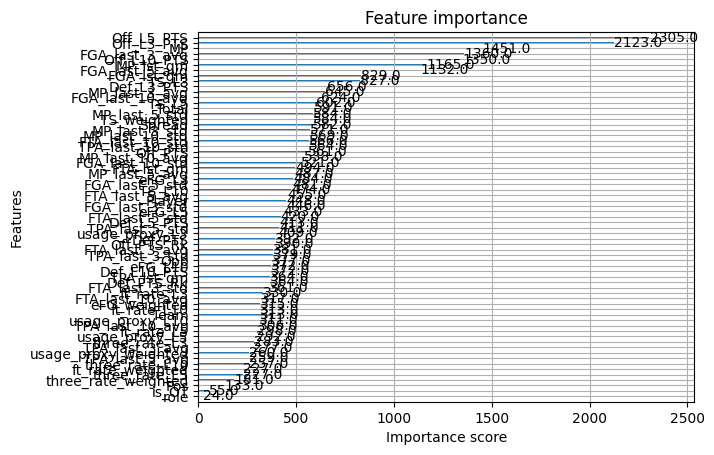

Saved PTS model!


In [94]:
df_main = df.copy()
df_main = setup_df_main(df_main)
display(df_main)

n = len(df_main)
train_end = int(0.65 * n)
val_end   = int(0.85 * n)
main_train_df = df_main.iloc[:train_end]
main_val_df   = df_main.iloc[train_end:val_end]
main_test_df  = df_main.iloc[val_end:]
main_DFS = (main_train_df, main_val_df, main_test_df)

# stat_model = create_baseline_model(df_main, tgt_stat, main_DFS)
stat_model, stat_preds, y_test_stat, analyze_df_stat = hyperparam_tuning(main_DFS, tgt_stat, n_iter=1)
feature_importance(stat_model)

# stat_model.save_model(f"../ML_models/{tgt_stat}_model.json")
# print(f'Saved {tgt_stat} model!')

In [89]:
# analyze_df_stat = main_test_df.drop([tgt_stat, f'{tgt_stat}_preds'], axis=1)\
#                 .merge(analyze_df_stat[['Date', 'Team', 'Player', tgt_stat, f'{tgt_stat}_preds']], on=['Date', 'Team', 'Player'])
# analyze_df_stat['Diff'] = analyze_df_stat[tgt_stat] - analyze_df_stat[f'{tgt_stat}_preds']
# analyze_df_stat[analyze_df_stat.MP > 38].sort_values('Diff', ascending=True).head(15)

In [90]:
rmse = np.sqrt(mean_squared_error(y_test_stat, stat_preds)) # splits[5] = y_test
mae = mean_absolute_error(y_test_stat, stat_preds)
print('RMSE:', rmse)

df_yesterday = pd.read_csv(f'../tables/2025/gmday_preds_{tgt_stat}.csv')
df_yesterday['Date'] = pd.to_datetime(df_yesterday.Date)
df_yesterday = df_yesterday[(df_yesterday.Date == (datetime.strptime(now, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d"))]\
                .rename(columns={"MP": "MP_proj"})

df_gms = pd.read_csv(f"../tables/2025/season_gamelogs.csv")
df_gms['Date'] = pd.to_datetime(df_gms.Date)
df_gms = df_gms.rename(columns={"TRB": "REB", "3PM": "TPM", "3PA": "TPA"})
df_gms['STL_BLK'] = df_gms.STL + df_gms.BLK
df_gms['PR'] = df_gms.PTS + df_gms.REB 
df_gms['PA'] = df_gms.PTS + df_gms.AST
df_gms['RA'] = df_gms.REB + df_gms.AST
df_gms['PRA'] = df_gms.PTS + df_gms.REB + df_gms.AST

df_yesterday = df_yesterday.merge(df_gms[['Date', 'Team', 'Player', tgt_stat, 'MP']], on=['Date', 'Team', 'Player'])
df_yesterday = df_yesterday[['Date', 'Team', 'Player', 'Pos', 'Opp', 'MP_proj', 'MP', f'{tgt_stat}_line', f'{tgt_stat}_proj', tgt_stat]][df_yesterday.MP > 0]

df_yesterday['Diff'] = df_yesterday[f'{tgt_stat}_proj'] - df_yesterday[f'{tgt_stat}_line']
df_yesterday['Diff2'] = abs(df_yesterday[f'{tgt_stat}_proj'] - df_yesterday[tgt_stat])
df_yesterday['Act_Res'] = np.where(df_yesterday[tgt_stat] > df_yesterday[f'{tgt_stat}_line'], 'O', 'U')
df_yesterday['Pred_Res'] = np.where(df_yesterday[f'{tgt_stat}_proj'] > df_yesterday[f'{tgt_stat}_line'], 'O', 'U')
df_yesterday['ParlayHit'] = np.where(df_yesterday['Act_Res'] == df_yesterday['Pred_Res'], 1, 0)
df_yesterday['InRMSE_Range'] = np.where(df_yesterday['Diff2'] <= rmse, 1, 0)

print("Total Accuracy (ParlayHit):", ((df_yesterday.ParlayHit == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.ParlayHit == 1).sum(), "/", df_yesterday.shape[0])

print("\nTotal Accuracy (InRMSE_Range):", ((df_yesterday.InRMSE_Range == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.InRMSE_Range == 1).sum(), "/", df_yesterday.shape[0])

df_yesterday = df_yesterday.drop(['Diff', 'Act_Res', 'Pred_Res'], axis=1).sort_values(f'{tgt_stat}_line', ascending=False)

if df_yesterday.shape[0] >= 50:
    for tm in df_yesterday.Team.unique():
        display(df_yesterday[df_yesterday.Team == tm])
else:
    display(df_yesterday)

RMSE: 3.5714520614045666
Total Accuracy (ParlayHit): 0.5194805194805194
40 / 77

Total Accuracy (InRMSE_Range): 0.36363636363636365
28 / 77


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
69,2026-01-02,LAL,Luka Doncic,PG,MEM,34.929024,37.55,52.5,53.066612,48,5.066612,0,0
71,2026-01-02,LAL,LeBron James,SF,MEM,33.844639,36.07,35.5,35.982960,46,10.017040,1,0
20,2026-01-02,LAL,Marcus Smart,SG,MEM,28.378506,34.28,15.5,19.589046,28,8.410954,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
35,2026-01-02,POR,Deni Avdija,SF,NOP,36.620758,38.40,45.5,42.349731,52,9.650269,0,0
74,2026-01-02,POR,Shaedon Sharpe,SG,NOP,32.689323,30.97,32.5,32.669868,29,3.669868,0,0
33,2026-01-02,POR,Donovan Clingan,C,NOP,27.523264,29.52,25.5,22.161173,27,4.838827,0,0
62,2026-01-02,POR,Toumani Camara,PF,NOP,33.552998,33.73,24.5,23.321051,24,0.678949,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
0,2026-01-02,MIL,Giannis Antetokounmpo,PF,CHO,28.056765,29.83,44.5,28.959274,45,16.040726,0,0
15,2026-01-02,MIL,Kevin Porter Jr.,PG,CHO,36.956581,36.02,31.5,36.208748,24,12.208748,0,0
41,2026-01-02,MIL,Ryan Rollins,PG,CHO,31.936579,36.95,24.5,27.304169,41,13.695831,1,0
44,2026-01-02,MIL,Myles Turner,C,CHO,29.648409,22.40,19.5,22.133821,7,15.133821,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
14,2026-01-02,ATL,Jalen Johnson,SF,NYK,35.602341,38.00,43.5,48.236008,39,9.236008,0,0
43,2026-01-02,ATL,Nickeil Alexander-Walker,SG,NYK,32.874153,34.32,26.5,29.153084,30,0.846916,1,1
2,2026-01-02,ATL,Onyeka Okongwu,C,NYK,33.483395,29.77,24.5,34.741920,34,0.741920,1,1
9,2026-01-02,ATL,Dyson Daniels,SG,NYK,34.442986,37.52,23.5,29.225847,25,4.225847,1,0
52,2026-01-02,ATL,Kristaps Porzingis,C,NYK,24.809210,17.27,20.5,22.658478,14,8.658478,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
7,2026-01-02,OKC,Shai Gilgeous-Alexander,PG,GSW,32.052265,28.18,41.5,35.206772,38,2.793228,1,1
24,2026-01-02,OKC,Jalen Williams,SG,GSW,29.439524,20.55,28.5,24.549906,20,4.549906,1,0
68,2026-01-02,OKC,Ajay Mitchell,SG,GSW,24.458542,25.08,17.5,16.867229,19,2.132771,0,1
61,2026-01-02,OKC,Cason Wallace,SG,GSW,26.384418,14.18,12.5,13.689125,6,7.689125,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
48,2026-01-02,NYK,Jalen Brunson,PG,ATL,36.169998,34.90,41.5,43.992634,31,12.992634,0,0
73,2026-01-02,NYK,OG Anunoby,PF,ATL,36.486786,34.98,26.5,26.247314,30,3.752686,0,0
27,2026-01-02,NYK,Mikal Bridges,SF,ATL,36.124950,35.15,25.5,21.743883,28,6.256117,0,0
47,2026-01-02,NYK,Tyler Kolek,PG,ATL,17.961246,17.23,12.5,15.039697,10,5.039697,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
3,2026-01-02,CLE,Donovan Mitchell,SG,DEN,31.797260,35.12,39.5,29.286524,44,14.713476,0,0
28,2026-01-02,CLE,Evan Mobley,PF,DEN,29.077856,32.28,29.5,25.772326,23,2.772326,1,1
50,2026-01-02,CLE,Darius Garland,PG,DEN,30.608122,32.15,28.5,26.171146,28,1.828854,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
37,2026-01-02,DEN,Jamal Murray,PG,CLE,35.179768,38.92,39.5,42.530418,47,4.469582,1,0
18,2026-01-02,DEN,Jalen Pickett,SG,CLE,18.316502,18.48,16.5,12.278925,14,1.721075,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
55,2026-01-02,ORL,Paolo Banchero,PF,CHI,35.897655,34.85,37.5,39.484852,43,3.515148,1,1
45,2026-01-02,ORL,Desmond Bane,SG,CHI,34.768715,37.77,32.5,29.881437,22,7.881437,1,0
8,2026-01-02,ORL,Anthony Black,PG,CHI,33.916729,33.25,25.5,31.789371,27,4.789371,1,0
46,2026-01-02,ORL,Jalen Suggs,PG,CHI,29.580309,20.07,23.5,26.107729,18,8.107729,0,0
58,2026-01-02,ORL,Wendell Carter Jr.,C,CHI,31.945587,31.77,22.5,24.063959,24,0.063959,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
4,2026-01-02,PHO,Devin Booker,SG,SAC,31.450600,27.73,36.5,27.664240,40,12.335760,0,0
65,2026-01-02,PHO,Dillon Brooks,SF,SAC,30.987740,25.43,25.5,24.361509,21,3.361509,1,1
72,2026-01-02,PHO,Collin Gillespie,PG,SAC,31.179739,26.05,24.5,24.046261,22,2.046261,1,1
63,2026-01-02,PHO,Royce O'Neale,SF,SAC,28.951508,30.12,16.5,15.332431,14,1.332431,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
1,2026-01-02,NOP,Zion Williamson,PF,POR,29.330368,30.70,36.5,24.569046,45,20.430954,0,0
29,2026-01-02,NOP,Jordan Poole,PG,POR,26.382700,29.80,25.5,21.908428,23,1.091572,1,1
59,2026-01-02,NOP,Jeremiah Fears,PG,POR,26.899406,29.17,22.5,21.107754,27,5.892246,0,0
31,2026-01-02,NOP,Yves Missi,C,POR,17.977770,20.95,16.5,13.063229,10,3.063229,1,1
11,2026-01-02,NOP,Jose Alvarado,PG,POR,18.476370,20.50,15.5,10.128999,7,3.128999,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
19,2026-01-02,SAS,De'Aaron Fox,PG,IND,33.682983,32.35,34.5,30.358419,35,4.641581,0,0
42,2026-01-02,SAS,Stephon Castle,PG,IND,31.503674,33.43,32.5,29.720804,35,5.279196,0,0
5,2026-01-02,SAS,Dylan Harper,SG,IND,19.919416,29.12,21.5,14.218723,25,10.781277,0,0
26,2026-01-02,SAS,Harrison Barnes,PF,IND,26.689491,21.00,18.5,14.732707,8,6.732707,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
40,2026-01-02,IND,Pascal Siakam,PF,SAS,33.309406,35.87,33.5,30.644312,37,6.355688,0,0
38,2026-01-02,IND,Bennedict Mathurin,SF,SAS,33.717758,19.77,26.5,23.492563,10,13.492563,1,0
34,2026-01-02,IND,Andrew Nembhard,PG,SAS,32.780666,35.55,26.5,29.760342,31,1.239658,1,1
64,2026-01-02,IND,Aaron Nesmith,SF,SAS,27.858086,29.08,19.5,18.360374,15,3.360374,1,1
76,2026-01-02,IND,T.J. McConnell,PG,SAS,17.346643,18.15,15.5,15.562861,19,3.437139,1,1
53,2026-01-02,IND,Jay Huff,C,SAS,17.100142,19.57,13.5,11.359291,6,5.359291,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
56,2026-01-02,CHO,LaMelo Ball,PG,MIL,29.609573,25.92,33.5,31.586094,21,10.586094,1,0
16,2026-01-02,CHO,Brandon Miller,SF,MIL,34.793015,30.28,27.5,32.141247,30,2.141247,1,1
6,2026-01-02,CHO,Miles Bridges,PF,MIL,29.768742,36.62,26.5,20.005722,33,12.994278,0,0
67,2026-01-02,CHO,Kon Knueppel,SF,MIL,31.962202,33.75,25.5,24.861748,33,8.138252,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
49,2026-01-02,MEM,Ja Morant,PG,LAL,30.045738,31.37,33.5,31.140554,30,1.140554,1,1
13,2026-01-02,MEM,Jaren Jackson Jr.,C,LAL,33.020767,30.30,27.5,32.544537,28,4.544537,1,0
75,2026-01-02,MEM,Cedric Coward,SG,LAL,29.437527,23.83,23.5,23.664713,17,6.664713,0,0
22,2026-01-02,MEM,Santi Aldama,PF,LAL,33.765907,29.80,23.5,27.527002,25,2.527002,1,1
70,2026-01-02,MEM,Cam Spencer,SG,LAL,23.616175,16.63,16.5,17.046686,12,5.046686,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
36,2026-01-02,CHI,Nikola Vucevic,C,ORL,30.240461,35.18,30.5,27.449482,32,4.550518,0,0
25,2026-01-02,CHI,Tre Jones,PG,ORL,26.375299,28.62,23.5,19.732300,11,8.732300,1,0
17,2026-01-02,CHI,Matas Buzelis,PF,ORL,25.983444,30.38,22.5,17.989983,37,19.010017,0,0
32,2026-01-02,CHI,Jalen Smith,C,ORL,21.313309,26.95,22.5,19.134321,22,2.865679,1,1
21,2026-01-02,CHI,Ayo Dosunmu,SG,ORL,26.318497,21.15,21.5,17.431623,27,9.568377,0,0
23,2026-01-02,CHI,Kevin Huerter,SF,ORL,23.641537,23.52,20.5,16.518833,26,9.481167,0,0
66,2026-01-02,CHI,Isaac Okoro,SG,ORL,25.096737,29.55,14.5,15.413272,13,2.413272,0,1
39,2026-01-02,CHI,Patrick Williams,PF,ORL,15.322885,22.90,12.5,9.642926,18,8.357074,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
10,2026-01-02,SAC,DeMar DeRozan,PF,PHO,32.778351,29.87,25.5,30.933712,18,12.933712,0,0
51,2026-01-02,SAC,Russell Westbrook,PG,PHO,28.795628,26.03,25.5,27.761063,32,4.238937,1,0
12,2026-01-02,SAC,Dennis Schroder,PG,PHO,27.381693,24.00,18.5,23.825369,16,7.825369,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
60,2026-01-02,WAS,CJ McCollum,SG,BRK,32.936527,31.12,25.5,24.263145,26,1.736855,0,1
54,2026-01-02,WAS,Bilal Coulibaly,SG,BRK,27.729412,29.17,17.5,19.488649,23,3.511351,1,1
77,2026-01-02,WAS,Khris Middleton,SF,BRK,22.256313,22.83,16.5,16.497766,15,1.497766,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
57,2026-01-02,GSW,Brandin Podziemski,SG,OKC,26.319727,26.3,21.5,19.84483,20,0.15517,1,1


### Today's predictions

In [91]:
df_lines = pd.read_csv(f"../tables/2025/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
df_lines = df_lines[~(df_lines.Team.isnull())]

# Predict Mins
df_lines["Team"] = team_encoder.transform(df_lines["Team"])
df_pred = df_pred.merge(df_lines[['Date', 'Team', 'Spread', 'Total']], on=['Date', 'Team'], how='left')
df_pred = df_pred[~df_pred[['Date', 'Team', 'Player']].duplicated(keep='last')]
df_pred['Spread_x'] = np.where(df_pred.Spread_x.isnull(), df_pred.Spread_y, df_pred.Spread_x)
df_pred['Total_x'] = np.where(df_pred.Total_x.isnull(), df_pred.Total_y, df_pred.Total_x)
df_pred = df_pred.rename(columns={"Spread_x": "Spread", "Total_x": "Total"}).drop(['Spread_y', 'Total_y'], axis=1)
df_pred_mins = setup_df_mins(con, df_pred)
df_pred_mins = df_pred_mins.drop(['Date', 'MP'], axis=1)
DM_mins = xgb.DMatrix(df_pred_mins)
df_pred['MP'] = mins_model.predict(DM_mins)

# Predict Stat
df_pred = setup_df_main(df_pred)
feature_cols = [col for col in df_pred.columns if col not in ['Date', tgt_stat]]
df_pred = df_pred[df_pred.Date == now][feature_cols]
DM_stats = xgb.DMatrix(df_pred)
df_pred[f"{tgt_stat}_proj"] = stat_model.predict(DM_stats)

df_pred['Team'] = team_encoder.inverse_transform(df_pred["Team"])
df_lines['Team'] = team_encoder.inverse_transform(df_lines["Team"])
df_pred['Opp'] = team_encoder.inverse_transform(df_pred["Opp"])
df_pred['Player'] = player_encoder.inverse_transform(df_pred["Player"])
df_pred['Pos'] = position_encoder.inverse_transform(df_pred["Pos"])

df_lines = df_lines[df_lines.Date == now][['Team', 'Player', f'{tgt_stat}_line']]
df_pred = df_pred.merge(df_lines, on=['Team', 'Player'])

tds_picks = df_pred[~(df_pred[f'{tgt_stat}_line'].isnull())]\
            [['Team', 'Player', 'Pos', 'Opp', 'MP', 'MP_last_5_avg', f'{tgt_stat}_line', f'{tgt_stat}_proj']]
tds_picks['Diff'] = abs((df_pred[f'{tgt_stat}_line'] - df_pred[f'{tgt_stat}_proj']))
tds_picks['Diff2'] = abs((df_pred['MP'] - df_pred['MP_last_5_avg']))
tds_picks = tds_picks.sort_values('Diff', ascending=False).drop(['Diff', 'Diff2'], axis=1)
if tds_picks.shape[0] >= 50:
    print(tds_picks.shape[0], 'rows')
    for tm in tds_picks.Team.unique():
        display(tds_picks[tds_picks.Team == tm])
else:
    display(tds_picks)
tds_picks.insert(0, 'Date', pd.to_datetime(now))
# partition_save_df(tds_picks, f"../tables/2025/gmday_preds_{tgt_stat}.csv")

80 rows


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
90,NYK,Karl-Anthony Towns,C,PHI,29.042278,31.995481,36.5,51.981499
51,NYK,Mikal Bridges,SF,PHI,35.502708,36.352514,26.5,21.951824
18,NYK,Tyler Kolek,PG,PHI,19.653011,20.863533,11.5,14.842887
29,NYK,Miles McBride,SG,PHI,29.443920,27.513057,18.5,20.629204
75,NYK,OG Anunoby,PF,PHI,35.853264,34.413653,27.5,25.970760
6,NYK,Jalen Brunson,PG,PHI,36.025703,36.683372,40.5,40.071613


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
4,SAS,Stephon Castle,PG,POR,32.238674,30.904600,33.5,24.663923
28,SAS,Dylan Harper,SG,POR,22.285381,20.920097,21.5,16.826956
2,SAS,De'Aaron Fox,PG,POR,32.618267,31.047412,32.5,28.154057
61,SAS,Julian Champagnie,SF,POR,26.780972,26.259726,20.5,18.720058
58,SAS,Keldon Johnson,SF,POR,23.232010,20.194812,21.5,19.956205


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
55,MIA,Jaime Jaquez Jr.,SF,MIN,31.359440,29.329121,24.5,32.461086
56,MIA,Andrew Wiggins,SF,MIN,32.025257,29.850057,22.5,30.163712
85,MIA,Nikola Jovic,PF,MIN,22.256557,14.302897,17.5,23.481775
25,MIA,Norman Powell,SG,MIN,33.245132,30.328770,30.5,32.614830
12,MIA,Davion Mitchell,PG,MIN,29.559626,27.175167,17.5,17.801426
91,MIA,Bam Adebayo,C,MIN,32.183769,30.183839,28.5,28.653725


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
35,DAL,Max Christie,SG,HOU,28.889446,26.815944,13.5,21.458141
13,DAL,Cooper Flagg,PG,HOU,36.627293,35.627627,29.5,33.380791
66,DAL,Anthony Davis,PF,HOU,33.896896,31.292986,34.5,37.903053
54,DAL,Naji Marshall,SF,HOU,28.782345,31.139875,15.5,18.061279
71,DAL,P.J. Washington,PF,HOU,32.596081,31.090414,21.5,19.824408


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
46,LAC,Kawhi Leonard,SF,BOS,37.514137,33.166865,39.5,46.602451
92,LAC,Ivica Zubac,C,BOS,23.777380,24.632458,22.5,16.824099
105,LAC,Brook Lopez,C,BOS,21.117916,20.235234,10.5,16.160397
5,LAC,James Harden,PG,BOS,36.494534,33.119485,37.5,35.255898
15,LAC,Kris Dunn,PG,BOS,28.379877,27.043107,12.5,13.894263
82,LAC,John Collins,PF,BOS,26.095699,26.120505,18.5,18.210838


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
0,UTA,Keyonte George,PG,GSW,34.676224,34.246101,35.5,41.881310
11,UTA,Isaiah Collier,PG,GSW,25.953739,23.908059,18.5,22.712486
63,UTA,Brice Sensabaugh,SF,GSW,28.923201,22.860447,21.5,18.753502


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
73,TOR,Scottie Barnes,PF,ATL,35.532780,34.656797,35.5,41.371197
48,TOR,Brandon Ingram,SF,ATL,35.903877,34.450864,33.5,30.209244
52,TOR,RJ Barrett,SF,ATL,26.613823,28.151837,23.5,21.000675
10,TOR,Immanuel Quickley,PG,ATL,33.490532,32.594419,28.5,27.932695


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
96,ATL,Onyeka Okongwu,C,TOR,33.783730,33.408888,29.5,34.592716
34,ATL,Dyson Daniels,SG,TOR,35.190514,33.822874,24.5,28.491055
60,ATL,Zaccharie Risacher,SF,TOR,22.650314,22.833168,15.5,13.541816
24,ATL,Nickeil Alexander-Walker,SG,TOR,33.473225,31.960632,26.5,27.702976
49,ATL,Jalen Johnson,SF,TOR,36.536137,35.315766,44.5,43.580788


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
79,GSW,Quinten Post,PF,UTA,18.566353,19.262933,14.5,9.526191
30,GSW,Moses Moody,SG,UTA,23.471573,23.470547,16.5,11.633122
3,GSW,Stephen Curry,PG,UTA,30.472389,33.344346,37.5,33.928871
76,GSW,Draymond Green,PF,UTA,22.816378,26.566425,20.5,21.985035
50,GSW,Jimmy Butler,SF,UTA,30.451509,32.383644,30.5,31.848846


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
42,CHO,Brandon Miller,SF,CHI,33.625130,32.790556,29.5,34.221695
65,CHO,Miles Bridges,PF,CHI,33.567657,32.405456,28.5,26.463634
44,CHO,Kon Knueppel,SF,CHI,32.106758,33.031681,28.5,27.728062
1,CHO,LaMelo Ball,PG,CHI,29.139229,28.059797,33.5,32.987583


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
20,POR,Shaedon Sharpe,SG,SAS,32.981533,31.507195,31.5,27.414663
45,POR,Deni Avdija,SF,SAS,36.676289,35.306483,42.5,39.824165
83,POR,Toumani Camara,PF,SAS,33.482746,31.907299,21.5,19.600151


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
97,MIN,Naz Reid,C,MIA,28.790710,29.117092,22.5,26.508232
19,MIN,Anthony Edwards,SG,MIA,36.473015,35.314589,39.5,35.896179
74,MIN,Jaden McDaniels,PF,MIA,30.011288,32.056298,21.5,18.004683
67,MIN,Julius Randle,PF,MIA,33.870277,32.912217,33.5,36.633205
99,MIN,Rudy Gobert,C,MIA,33.484898,31.112872,24.5,21.784399
27,MIN,Donte DiVincenzo,SG,MIA,31.234711,31.398614,21.5,22.039293


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
22,PHI,VJ Edgecombe,SG,NYK,35.883888,34.296962,24.5,28.475574
94,PHI,Joel Embiid,C,NYK,33.853928,29.916281,37.5,40.768780
7,PHI,Tyrese Maxey,PG,NYK,38.537258,37.689861,39.5,42.670853
70,PHI,Paul George,PF,NYK,34.006474,31.541412,25.5,24.001245
23,PHI,Quentin Grimes,SG,NYK,32.478474,31.476245,17.5,17.427694


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
103,BOS,Neemias Queta,C,LAC,26.417492,26.573041,19.5,16.074739
21,BOS,Derrick White,SG,LAC,36.345394,34.635878,28.5,30.726063
26,BOS,Anfernee Simons,SG,LAC,26.626776,26.210135,16.5,18.347652
41,BOS,Jaylen Brown,SF,LAC,34.057961,31.965212,40.5,41.937210
14,BOS,Payton Pritchard,PG,LAC,34.097481,33.128761,25.5,26.606424


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
53,CHI,Kevin Huerter,SF,CHO,23.162352,21.892814,20.5,17.325092
31,CHI,Ayo Dosunmu,SG,CHO,24.601667,24.382504,22.5,19.628553
95,CHI,Nikola Vucevic,C,CHO,32.006721,28.018726,31.5,29.245956
36,CHI,Isaac Okoro,SG,CHO,25.507620,21.294262,14.5,16.246567
102,CHI,Jalen Smith,C,CHO,22.941174,17.954200,23.5,22.147346
8,CHI,Tre Jones,PG,CHO,27.756878,25.203004,23.5,22.447687
69,CHI,Matas Buzelis,PF,CHO,28.212631,26.100481,24.5,24.129606


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
47,HOU,Amen Thompson,SF,DAL,36.763721,33.954417,29.5,32.259216
9,HOU,Reed Sheppard,PG,DAL,29.135242,26.583956,18.5,21.213430
72,HOU,Jabari Smith Jr.,PF,DAL,35.389652,32.588446,23.5,25.387255
43,HOU,Kevin Durant,SF,DAL,36.559185,33.578714,35.5,37.009727
89,HOU,Alperen Sengun,C,DAL,35.135010,31.942224,36.5,36.810818


In [84]:
df_pred[df_pred.Player == 'Nickeil Alexander-Walker']

,Team,Opp,Player,Pos,MP,Off_PTS,Off_L3_PTS,Off_L5_PTS,Off_L10_PTS,Off_PTS_Rk,Def_PTS,Def_L3_PTS,Def_L5_PTS,Def_L10_PTS,Def_PTS_Rk,Spread,Total,is_OT,three_rate_L3,ft_rate_L3,eFG_L3,TS_L3,usage_proxy_L3,three_rate_L5,ft_rate_L5,eFG_L5,TS_L5,usage_proxy_L5,three_rate_L10,ft_rate_L10,eFG_L10,TS_L10,usage_proxy_L10,three_rate_weighted,ft_rate_weighted,eFG_weighted,TS_weighted,usage_proxy_weighted,MP_lst_gm,MP_last_3_avg,MP_last_3_std,MP_last_5_avg,MP_last_5_std,MP_last_10_avg,MP_last_10_std,FGA_lst_gm,FGA_last_3_avg,FGA_last_3_std,FGA_last_5_avg,FGA_last_5_std,FGA_last_10_avg,FGA_last_10_std,TPA_lst_gm,TPA_last_3_avg,TPA_last_3_std,TPA_last_5_avg,TPA_last_5_std,TPA_last_10_avg,TPA_last_10_std,FTA_lst_gm,FTA_last_3_avg,FTA_last_3_std,FTA_last_5_avg,FTA_last_5_std,FTA_last_10_avg,FTA_last_10_std,role,PTS_proj,PTS_line
24,ATL,TOR,Nickeil Alexander-Walker,SG,33.473225,20.411765,21.333333,20.8,19.7,9.0,25.088235,26.0,29.8,24.2,10.0,4.5,231.5,0,0.555556,0.108333,0.522222,0.526414,0.617567,0.538095,0.12373,0.53,0.546245,0.579652,0.494486,0.180725,0.485687,0.516608,0.574028,0.544211,0.120192,0.520902,0.531383,0.601839,32.281345,31.4737,1.670294,31.960632,1.495504,32.678662,12.691482,20.0,18.666667,5.507571,17.6,4.32435,17.3,7.693793,10.0,10.333333,2.081666,9.6,1.643168,8.6,3.708099,4.0,2.333333,2.081666,2.4,1.732051,3.2,2.788867,1,20.859314,20.5
